In [2]:
from sklearn.datasets import load_iris,load_diabetes
from sklearn.model_selection import train_test_split
from scipy import stats
import numpy as np 
from matplotlib import pyplot as plt
import math
import os 


### Intuition 
There exists a large variety of algorithms to build desicion trees. Below we just consider the simples of all setup, spatial desicion trees because this is what is typically used in random forest.

To construct he tree, we peoceed recursivly. In each step, we select one dimension along which we are going to split the current cell. We on splitting cells until they contain only few data points. To predict the regression/classification output for a test, we determine in which cell the test point, consider the labels of all training points in this cell and the predict the average value (in case of regression) or the majority vote (in case of classification) for the test point. 

</br>

***
### Splitting criterion
To build the tree we need a criterion to evaluate the quality of a proposed data split. There are many such critera. As an example consider the resulting training error on both sides: 

Consider a split of the data into two sets, called $A$ and $A^{c}$
-  For all training points in $A$, we would predict the outcome $\hat{Y}_{A} = mean(\{Y_i | X_i \in A \})$
-  Similarly, for points in $A^{c}$ we would predict the mean $\hat{Y}_{A^{c}}$
-  We can now compute the sum of the least squares error we would achieve on both sides:</br>
$Error_{split} = \sum_{i \in A} (Y_{A} - Y_{i})^2 + \sum_{i \in A^c} (Y_{A^c} - Y_{i})^2$

Typically, spatial desicion trees use axis-parallel splits. Given the current cell, they select one dimension along which to split next according to the splitting error. 
- For all dimensions $k = 1,...,d:$
    -  Find the best splitting point $s_k$ along this dimension $k$ by optimizing the splitting error and store the resulting splitting points $s_k$ and splitting error $error_{splitt,k}$
- Select the dimension with the smallest spitting error and the the correspoonding split 

</br>

***
### Spacial decision trees: Depth of the tree

Typically, we keep on splitting cells untill they contain less then a pre defined number $n_leaf$ of points. Different rules of thumb exists: 
- To achieve statistical consistenc of the desicion tree, the number of points per leaf need to increase with the number $n$ of training points. For example $n_{leaf} = log(n)$ leads to consistency. The resulting trees are sometfrom sklearn.datasets import load_irisimes called "shallow trees"
- In practice, in random forest one often uses "deep trees" that always contains only a constant number of points in the leaf. If we just used a single desicion tree, this procedure would be a disaster (overfitting). But in random forest it can lead to a consistent forest in the end.

# Regression

#### Utility

In [3]:
### Kernels 
gaussianKernel = lambda x : (1 / math.sqrt(2 * math.pi)) * np.exp( -(1/2) * np.power(x, 2))

In [4]:
def plotGrid(data, target, features, plot):
    # Cast to vectors and matrecies
    _Y = np.atleast_2d(target); _X = np.atleast_2d(data);
    
    # Calculate dimensions
    col = math.ceil(math.sqrt(_X.shape[1]))
    row = math.ceil(_X.shape[1] / col)
    
    fig, axis = plt.subplots(row,col)
    for idx, ax in enumerate(axis.ravel()):
        
        # If axis should not be included
        if( idx >= _X.shape[1]): break
        else: plot(ax, _X[:, idx], _Y, features[idx])
    
def plotFunction(func, **kwargs): 
    return lambda ax,x,y,feature: func(ax,x,y,feature, **kwargs)  
    
def scatterPlot(ax,x,y,f):
    ax.scatter(x, y);
    ax.set_ylabel("Target")
    ax.set_title(f);  
    
def distributionPlot(ax,x,y,f, h=0.01, n=100):
    # Samples and domain
    x_i = x.reshape(1,len(x));
    xx = np.linspace(min(x), max(x), n).reshape(n,1)
    
    # Kernel density estimation
    z = (xx - x_i) / h
    y = np.sum(gaussianKernel(z), axis=1) / (n*h)
    
    #ax.plot(x, y);
    counts, bins = np.histogram(x_i, bins=10)
    ax.plot(xx, y);
    ax.set_ylabel("Target")
    ax.set_title(f);  
            


### Data extraction

In [11]:
data, target, _, desc, feature_names, _, _ = load_diabetes().values()

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.33, random_state=42)

In [12]:
X_train

array([[ 0.0090156 , -0.04464164, -0.03099563, ..., -0.00259226,
         0.00943641,  0.01134862],
       [-0.00188202, -0.04464164,  0.05415152, ...,  0.08486339,
         0.08449528,  0.04862759],
       [ 0.0090156 ,  0.05068012, -0.00512814, ...,  0.07120998,
         0.03953988,  0.01963284],
       ...,
       [ 0.03081083, -0.04464164, -0.02021751, ..., -0.03949338,
        -0.01090444, -0.0010777 ],
       [-0.01277963, -0.04464164, -0.02345095, ..., -0.00259226,
        -0.03845911, -0.03835666],
       [-0.09269548, -0.04464164,  0.02828403, ..., -0.03949338,
        -0.00514531, -0.0010777 ]])

### Data exploration

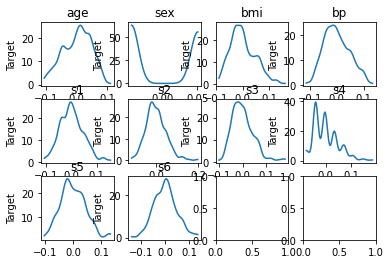

In [13]:
plotGrid(X_train, y_train, feature_names, plotFunction(distributionPlot, h=0.01))


### Model development

In [398]:
X, Y, _, desc, feature_names, _, _ = load_iris().values()
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [1]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
    
    def is_leaf(self):
        return self.value is not None
        
                      
        
class DesicionTree:
    
    def __init__(self, max_depth=100, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None
        self.criteria = dict(
            gini = lambda y: np.sum([np.log2(p) * p for p in np.bincount(y.ravel()) / len(y) if p > 0]),
            l2   = lambda x: x,
        )
    
    def fit(self, X, y):
        self.root = self._build_tree(X, y.ravel())
        return self
        
    def _information_gain(self, n, total_loss, n_left, left_loss, n_rigth, right_loss):
        # Calculate information gain
        if n_left == 0 or n_rigth == 0: 
            return 0
        return total_loss - ((n_left / n) * left_loss + (n_rigth / n) * right_loss)
    
    def _create_split(self, data, split):
        # Split data based on split point
        left_idx = np.argwhere(data <= split).flatten()
        right_idx = np.argwhere(data > split).flatten()
        return left_idx, right_idx
        
    def _get_split(self, X, y, criteria='gini'):
        score = []      
        total_loss = self.criteria[criteria](y)
        
        for dimension, data in enumerate(X.T):
            for split in np.unique(data):
                # Get indices of each group given the split
                left_idx, right_idx = self._create_split(data, split)

                # Get loss of each group given the split
                left_loss = self.criteria[criteria](y[left_idx])
                right_loss = self.criteria[criteria](y[right_idx])
                
                # Calculate information gain
                ig = self._information_gain(len(y) ,total_loss, len(left_idx), left_loss, len(right_idx), right_loss)
                score.append((ig, dimension, split))   
                
        return min(score, key = lambda e: e[0])
    
    
    def _build_tree(self, X, y, depth=0):
        self.n_samples, self.n_features = X.shape
        self.n_class_labels = len(np.unique(y))
        
        (ig, dimension, split) = self._get_split(X, y)
        left_idx, right_idx = self._create_split(X[:, dimension], split)
        
        # stopping criteria
        if (depth >= self.max_depth 
            or self.n_class_labels == 1 
            or self.n_samples < self.min_samples_split
            or len(left_idx) == 0 
            or len(right_idx) == 0      
           ):
            most_common_Label = np.argmax(np.bincount(y))       
            return Node(value=most_common_Label)
        else:
            left_child = self._build_tree(X[left_idx, :], y[left_idx], depth + 1)
            right_child = self._build_tree(X[right_idx, :], y[right_idx], depth + 1)
            return Node(feature=dimension, threshold=split, left=left_child, right=right_child)

    def _traverse_tree(self, x, node):
        if node.is_leaf(): 
            return node.value  
        if x[node.feature] <= node.threshold: 
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)
            
    def predict(self, X):
        predictions = [self._traverse_tree(x, self.root) for x in X]
        return np.array(predictions)
    
    
model = DesicionTree();
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print( np.sum(y_test == y_pred) / len(y_test))

NameError: name 'X_train' is not defined

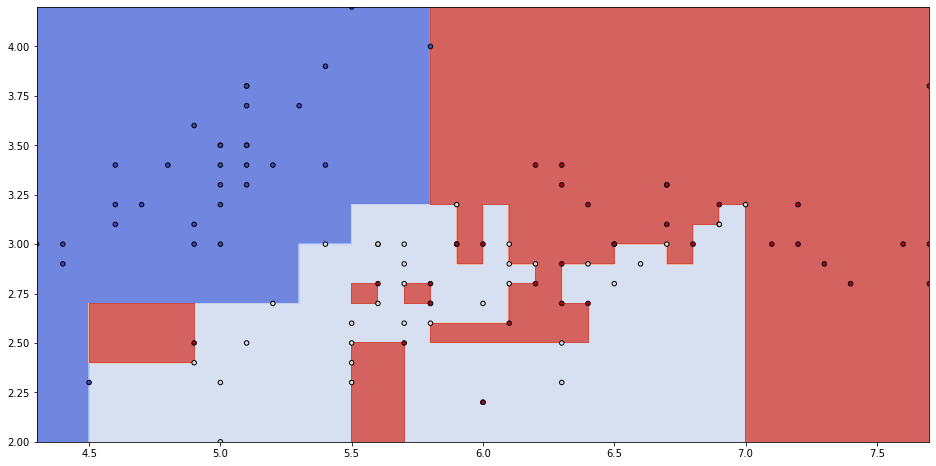

In [400]:
model = DesicionTree()

fig, axis = plt.subplots(1, 1, figsize=(16,8), sharey=True)

x1_min, x2_min, x3_min, x4_min = np.min(X_train, axis=0)
y1_min, y2_min, y3_min, y4_min = np.max(X_train, axis=0)

xx, yy = np.meshgrid(np.linspace(x1_min, y1_min, 1000), np.linspace(x2_min, y2_min, 1000))
Z = model.fit(X_train[:, [0,1]], y_train).predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

axis.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8);
axis.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap=plt.cm.coolwarm, s=20, edgecolors='k');


In [401]:
X, Y, _, desc, feature_names, _, _ = load_diabetes().values()
X_train, X_test, y_train, y_test = train_test_split(X[:,[0,2,3]], Y, test_size=0.33, random_state=42)

In [402]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
    
    def is_leaf(self):
        return self.value is not None
        
                      
        
class DesicionTree:
    
    def __init__(self, max_depth=100, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None
        self.criteria = dict(
            l2   = lambda x: np.sum(np.power((x - np.mean(x)), 2)),
        )
    
    def fit(self, X, y):
        self.root = self._build_tree(X, y.ravel())
        return self
        
    def _information_gain(self, n_left, left_loss, n_rigth, right_loss):
        # Calculate information gain
        return (left_loss + right_loss)
    
    def _create_split(self, data, split):
        # Split data based on split point
        left_idx = np.argwhere(data <= split).flatten()
        right_idx = np.argwhere(data > split).flatten()
        return left_idx, right_idx
        
    def _get_split(self, X, y, criteria='l2'):
        scores = []      
        
        for dimension, data in enumerate(X.T):
            total_loss = self.criteria[criteria](data)
            for split in np.unique(data):
                # Get indices of each group given the split
                left_idx, right_idx = self._create_split(data, split)

                # Get loss of each group given the split
                left_loss = self.criteria[criteria](data[left_idx])
                right_loss = self.criteria[criteria](data[right_idx])
                
                # Calculate information gain
                ig = self._information_gain(len(left_idx), left_loss, len(right_idx), right_loss)
                scores.append((ig, dimension, split)) 
        score = min(scores, key = lambda e: e[0])
        return score
    
    
    def _build_tree(self, X, y, depth=0):
        self.n_samples, self.n_features = X.shape
        
        (ig, dimension, split) = self._get_split(X, y)
        left_idx, right_idx = self._create_split(X[:, dimension], split)
        
        # stopping criteria
        if (depth >= self.max_depth 
            or self.n_samples < self.min_samples_split
            or len(left_idx) == 0 
            or len(right_idx) == 0      
           ):    
            return Node(value=np.mean(y))
        else:
            left_child = self._build_tree(X[left_idx, :], y[left_idx], depth + 1)
            right_child = self._build_tree(X[right_idx, :], y[right_idx], depth + 1)
            return Node(feature=dimension, threshold=split, left=left_child, right=right_child)

    def _traverse_tree(self, x, node):
        if node.is_leaf(): 
            return node.value  
        if x[node.feature] <= node.threshold: 
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)
            
    def predict(self, X):
        predictions = [self._traverse_tree(x, self.root) for x in X]
        return np.array(predictions)
    
    

C:\Users\medde\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\medde\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


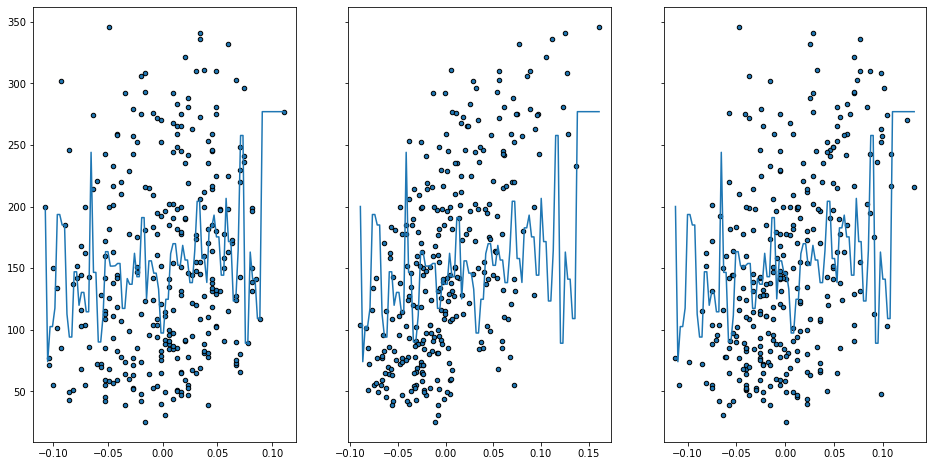

In [403]:
model = DesicionTree()

fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(16,8), sharey=True)

x0_min, x1_min, x2_min = np.min(X_train, axis=0)
x0_max, x1_max, x2_max = np.max(X_train, axis=0)

x0 = np.linspace(x0_min, x0_max, 100); 
x1 = np.linspace(x1_min, x1_max, 100);
x2 = np.linspace(x2_min, x2_max, 100);

x = np.array([x0,x1,x2]).T
y = model.fit(X_train, y_train).predict(x)


ax1.plot(x0,y)
ax1.scatter(X_train[:, 0], y_train, cmap=plt.cm.coolwarm, s=20, edgecolors='k');

ax2.plot(x1,y)
ax2.scatter(X_train[:, 1], y_train, cmap=plt.cm.coolwarm, s=20, edgecolors='k');

ax3.plot(x2,y)
ax3.scatter(X_train[:, 2], y_train, cmap=plt.cm.coolwarm, s=20, edgecolors='k');
